# 4.11.08 Convolutional neural network

## Task 1: ConvNet with original images
You tested different models with the set of high-level features extracted from a pretrained neural network. However, can you get similar results by creating a ConvNet from scratch and using the pixel values from the original images to train the model?

* What accuracy can you achieve?
* Can you get good results? - If not, why?


In [23]:
# import command
import numpy as np
import pandas as pd

_Consideration: The number of samples is small, therefore overfitting is likely to occur. With data augmentation I try provide additional images . I applied 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images._

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# apply data augmentation to improve overfitting
train_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5,
                    fill_mode='nearest')


validation_generator = ImageDataGenerator(rescale=1./255) 
test_generator = ImageDataGenerator(rescale=1./255)

In [27]:
# import command
import os

# Train, validation and test sets
trainset = train_generator.flow_from_directory(
    os.path.join("resources/swissroads", "train"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size= 280,
    class_mode = 'sparse',
    shuffle=True)

validset = validation_generator.flow_from_directory(
    os.path.join("resources/swissroads", "valid"),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size= 139,
    class_mode = 'sparse',
    shuffle=True)

testset = test_generator.flow_from_directory(
    os.path.join("resources/swissroads", "test"), 
    target_size=(224, 224), 
    color_mode="rgb",
    batch_size= 50,
    class_mode = 'sparse',
    shuffle=True)


Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [28]:
import tensorflow.keras as keras

# Convolutional Network
model = keras.Sequential()

# Convolutional layer & Max pooling layer
model.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, activation="relu", input_shape=(224, 224, 3)))
model.add(keras.layers.MaxPool2D(pool_size=2))

# 2nd convolutional layer & Max pooling layer
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=2))

# Flatten layer
model.add(keras.layers.Flatten())

# Output layer
model.add(keras.layers.Dense(units=trainset.num_classes, activation="softmax"))

#summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 110, 110, 64)      4864      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 55, 55, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 53, 53, 64)        36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 26, 26, 64)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 43264)             0         
                                                                 
 dense_8 (Dense)             (None, 6)                

In [29]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(), 
              loss="sparse_categorical_crossentropy", 
              metrics=["acc"])

In [30]:
# End training when accuracy stops improving
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, verbose=1)

In [31]:
# Train model
history = model.fit(
    trainset, validation_data=validset, epochs=100, callbacks=[early_stopping]
)

Epoch 1/100
1/1 [==============================] - 21s 21s/step - loss: 1.7807 - acc: 0.2143 - val_loss: 3.3203 - val_acc: 0.2374
Epoch 2/100
1/1 [==============================] - 20s 20s/step - loss: 3.1758 - acc: 0.2321 - val_loss: 1.9637 - val_acc: 0.2734
Epoch 3/100
1/1 [==============================] - 14s 14s/step - loss: 1.9326 - acc: 0.2893 - val_loss: 1.8034 - val_acc: 0.1511
Epoch 4/100
1/1 [==============================] - 12s 12s/step - loss: 1.8085 - acc: 0.1500 - val_loss: 1.9087 - val_acc: 0.1511
Epoch 5/100
1/1 [==============================] - 12s 12s/step - loss: 1.9064 - acc: 0.1500 - val_loss: 1.8592 - val_acc: 0.1511
Epoch 6/100
1/1 [==============================] - 19s 19s/step - loss: 1.8573 - acc: 0.1500 - val_loss: 1.7914 - val_acc: 0.1511
Epoch 7/100
1/1 [==============================] - 12s 12s/step - loss: 1.7889 - acc: 0.1500 - val_loss: 1.7602 - val_acc: 0.2446
Epoch 8/100
1/1 [==============================] - 17s 17s/step - loss: 1.7566 - acc: 0.22

### Loss and accuracy curves

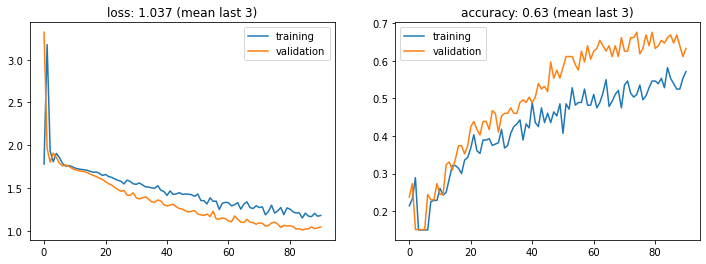

In [33]:
# import command
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title("loss: {:.3f} (mean last 3)".format(np.mean(history.history["val_loss"][-3:])))
ax1.plot(history.history["loss"], label="training")
ax1.plot(history.history["val_loss"], label="validation")
ax1.legend()

# plot accuracy values
ax2.set_title("accuracy: {:.2f} (mean last 3)".format(np.mean(history.history["val_acc"][-3:])))
ax2.plot(history.history["acc"], label="training")
ax2.plot(history.history["val_acc"], label="validation")
ax2.legend()

plt.show()

_Observation: The accuracy curves are both increasing, but they have a drop at around epoche 3 to 6. The loss curves decrease strongly at the beginning and continue to decrease continuely._

### Confusion matrix

In [34]:
test_preds = model.predict(testset)
print("Predictions:", test_preds.shape)

1/1 [==============================] - 1s 561ms/step
Predictions: (50, 6)


In [35]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute confusion matrix
matrix = confusion_matrix(
    y_true=testset.classes,  # array with true labels
    y_pred=test_preds.argmax(axis=1),  # array with predicted labels
)

# Format as a DataFrame
class_names = list(testset.class_indices.keys())
matrix_df = pd.DataFrame(data=matrix, columns=class_names, index=class_names)
matrix_df.columns.name = "Predictions"
matrix_df.index.name = "True class"
matrix_df

Predictions,bike,car,motorcycle,other,truck,van
True class,,,,,,
bike,2,6,2,0,1,1
car,2,5,4,0,0,0
motorcycle,2,1,3,2,1,0
other,0,2,0,0,3,1
truck,1,2,4,0,0,0
van,1,3,1,0,0,0


In [36]:
test_loss, test_acurracy = model.evaluate(testset)
print("Test loss: {:.2f}, accuracy: {:.2f}%".format(test_loss, test_acurracy * 100))

1/1 [==============================] - 0s 494ms/step - loss: 1.1180 - acc: 0.6000
Test loss: 1.12, accuracy: 60.00%


_Observation: The CNN model has a lower accuracy than the other model. To achieve better results, I would have to tunne the hyperparameters and improve the network design. A greater amount of training data would be helpful. Another reason why the results is not good, is that the model is based on the images themselves and not on the high-level features._